In [1]:
!pip install surya-ocr==0.8.3
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 44.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 88.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: pillow 11.0.0
    Uninstalling pillow-11.0.0:
      Successfully uninstalled pillow-11.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.4 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is in

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import glob as glob
import random
import json
from torch.optim import AdamW
from jiwer import wer, cer
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.optim import AdamW
import torch.nn as nn
from datasets import Dataset as HFDataset
from PIL import Image
from zipfile import ZipFile
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from urllib.request import urlretrieve
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)

from surya.ocr import run_ocr
from surya.model.detection.model import load_model as load_det_model, load_processor as load_det_processor
from surya.model.recognition.model import load_model as rec_model
from surya.model.recognition.processor import load_processor as rec_processor
from surya.detection import batch_text_detection
from surya.postprocessing.math.latex import fix_math, contains_math
from surya.postprocessing.text import truncate_repetitions
from surya.settings import settings


from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

import torch
from tqdm import tqdm
from torch.cuda.amp import autocast
import torch.nn.functional as F

In [3]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:         int = 5
    ACCUMULATION_STEPS: int = 4
    EPOCHS:             int = 40
    LEARNING_RATE:      float = 0.00005

In [4]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# List of data folders
data_folders = [
    '/kaggle/input/tr-ocr-data/Validation/Validation',
    '/kaggle/input/tr-ocr-data/annotated_so_far/annotated_so_far',
    '/kaggle/input/tr-ocr-data/folder_7/folder_7',
    '/kaggle/input/tr-ocr-data/folder_8/folder_8',
    '/kaggle/input/tr-ocr-data/folder_9/folder_9'
]

# Initialize an empty list to store data
data = []

# Iterate over each folder in the list
for folder in data_folders:
    # Iterate over each file in the current folder
    for file in os.listdir(folder):
        if file.endswith('.png'):
            # Get the base name without extension
            base_name = os.path.splitext(file)[0]

            # Define paths for image and text file
            image_path = os.path.join(folder, f"{base_name}.png")
            text_path = os.path.join(folder, f"{base_name}.txt")

            # Check if the corresponding text file exists
            if os.path.isfile(text_path):
                # Read the text file content
                with open(text_path, 'r', encoding='utf-8') as text_file:
                    text_content = text_file.read().strip()

                # Append data to the list
                data.append({'file_name': image_path, 'text': text_content})

# Create DataFrame from the combined data
combined_df = pd.DataFrame(data)

In [6]:
print(f"Total samples: {len(combined_df)}")

Total samples: 5317


In [7]:
# Remove rows with empty or whitespace-only texts
df_cleaned = combined_df[combined_df['text'].str.strip() != ""]

# # Optionally, remove rows with very short texts (e.g., less than 5 characters)
# min_text_length = 2
# df_cleaned = df_cleaned[df_cleaned['text'].str.len() >= min_text_length]

# # Reset index after filtering
# df_cleaned = df_cleaned.reset_index(drop=True)

In [8]:
# Function to clean, fix, and convert all numbers to Arabic numerals
def fix_and_convert_all_numbers_to_arabic(text):
    # Remove invisible bidi markers (\u200e, \u200f)
    cleaned_text = text.replace("\u200f", "").replace("\u200e", "").strip()
    
    # Translation table: English numbers to Arabic numbers
    english_to_arabic_numbers = str.maketrans("0123456789", "٠١٢٣٤٥٦٧٨٩")
    
    # Convert all numbers in the text
    converted_text = cleaned_text.translate(english_to_arabic_numbers)
    
    return converted_text

# Apply the function to the "text" column
df_cleaned["text"] = df_cleaned["text"].apply(fix_and_convert_all_numbers_to_arabic)
df_cleaned.reset_index(drop=True,inplace=True)

<ipython-input-8-093af3670e24>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["text"] = df_cleaned["text"].apply(fix_and_convert_all_numbers_to_arabic)


In [9]:
from sklearn.model_selection import train_test_split

# First, split into train and temp (validation + test)
train_df, temp_df = train_test_split(df_cleaned, test_size=0.3)

# Split temp into validation and test sets
val_df, test_df = train_test_split(temp_df, test_size=0.5)

# Display the sizes of each set
print(f"Total samples: {len(df_cleaned)}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")

train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)

train_df = HFDataset.from_pandas(train_df)
val_df = HFDataset.from_pandas(val_df)
test_df = HFDataset.from_pandas(test_df)

Total samples: 4297
Training samples: 3007
Validation samples: 645
Testing samples: 645


In [9]:
train_df

Dataset({
    features: ['file_name', 'text'],
    num_rows: 3007
})

# Loading the model and the processor

In [ ]:
import os
import json
import torch
from transformers import AutoTokenizer, AutoProcessor  # If you have a tokenizer or processor
from surya.model.recognition.encoderdecoder import OCREncoderDecoderModel
from surya.model.recognition.config import DonutSwinConfig, SuryaOCRConfig, SuryaOCRDecoderConfig, SuryaOCRTextEncoderConfig
from surya.model.recognition.encoder import DonutSwinModel
from surya.model.recognition.decoder import SuryaOCRDecoder, SuryaOCRTextEncoder
from surya.settings import settings

def load_finetuned_model(save_directory, device=settings.TORCH_DEVICE_MODEL, dtype=settings.MODEL_DTYPE) -> OCREncoderDecoderModel:
    # Step 1: Load the model's configuration
    config_path = os.path.join(save_directory, "config.json")
    with open(config_path, "r", encoding="utf-8") as f:
        config_dict = json.load(f)
    
    config = SuryaOCRConfig.from_dict(config_dict)
    decoder_config = config.decoder
    decoder = SuryaOCRDecoderConfig(**decoder_config)
    config.decoder = decoder

    encoder_config = config.encoder
    encoder = DonutSwinConfig(**encoder_config)
    config.encoder = encoder

    text_encoder_config = config.text_encoder
    text_encoder = SuryaOCRTextEncoderConfig(**text_encoder_config)
    config.text_encoder = text_encoder

    # Step 2: Load the model's state dictionary
    model_path = os.path.join(save_directory, "pytorch_model.bin")
    model = OCREncoderDecoderModel(config)
    model.load_state_dict(torch.load(model_path, map_location=device))

    # Step 3: Load the tokenizer (if applicable)
    if os.path.exists(os.path.join(save_directory, "tokenizer")):
        tokenizer = AutoTokenizer.from_pretrained(save_directory)
        model.tokenizer = tokenizer

    # Step 4: Load the processor (if applicable)
    if os.path.exists(os.path.join(save_directory, "processor")):
        processor = AutoProcessor.from_pretrained(save_directory)
        model.processor = processor

    # Step 5: Load generation config (if applicable)
    generation_config_path = os.path.join(save_directory, "generation_config.json")
    if os.path.exists(generation_config_path):
        with open(generation_config_path, "r", encoding="utf-8") as f:
            generation_config_dict = json.load(f)
        model.generation_config = generation_config_dict

    # Step 6: Load preprocessor config (if applicable)
    preprocessor_config_path = os.path.join(save_directory, "preprocessor_config.json")
    if os.path.exists(preprocessor_config_path):
        with open(preprocessor_config_path, "r", encoding="utf-8") as f:
            preprocessor_config = json.load(f)
        model.preprocessor_config = preprocessor_config

    # Move the model to the specified device and set it to evaluation mode
    model = model.to(device).to(torch.float32)
    # model = model.eval()

    print(f"Loaded fine-tuned model from {save_directory} on device {device} with dtype {dtype}")
    return model

In [ ]:
# model = load_finetuned_model("/kaggle/input/surya_recognitionmodel/pytorch/default/2/fine_tuned_surya_ocr_v2")
# processor = rec_processor()

## loading the original model

In [10]:
processor = rec_processor()

model = rec_model().to(device)
model.to(torch.float32)

Loaded recognition model vikp/surya_rec2 on device cuda with dtype torch.float16


OCREncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0): DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                )
                (output): DonutSwinSelfOutput(
              

In [11]:
# Set special tokens used for creating the decoder_input_ids from the labels.
# model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
processor.tokenizer.cls_token_id = model.config.decoder_start_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# Set Correct vocab size.
model.config.vocab_size = model.config.decoder.vocab_size
processor.tokenizer.sep_token_id = model.config.eos_token_id
 

# model.config.max_length = 256
# model.config.early_stopping = True
# model.config.no_repeat_ngram_size = 3
# model.config.length_penalty = 2.0
# model.config.num_beams = 2

### Agumentation

In [21]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define an augmentation pipeline
augmentation = A.Compose([
    A.Rotate(limit=10, p=0.5),  # Random rotation between -10 and 10 degrees
    # A.RandomCrop(height=224, width=224, p=0.5),  # Random crop to a fixed size
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),  # Random color jitter
    # A.HorizontalFlip(p=0.5),  # Random horizontal flip with 50% probability
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
    ToTensorV2(),  # Convert to tensor
])

In [25]:
# from torch.utils.data import Dataset
# from PIL import Image
# import torch
# from torch.nn.utils.rnn import pad_sequence

# class HuggingFaceOCRDataset(Dataset):
#     def __init__(self, hf_dataset, processor):
#         self.hf_dataset = hf_dataset
#         self.processor = processor

#     def __len__(self):
#         return len(self.hf_dataset)

#     def __getitem__(self, idx):
#         item = self.hf_dataset[idx]
#         image = Image.open(item["file_name"]).convert("RGB")  # Load image
#         text = item["text"]  # Get text label

#         # Process the image and text using the Surya-OCR processor
#         processed = self.processor(
#             text=text, 
#             images=image,
#             langs=[['ar']],
#             padding="longest",
#             truncation=True, 
#             return_tensors="pt"
#         )

#         # Ensure labels are a tensor
#         labels = processed["labels"]
#         if isinstance(labels, list):  # Convert list to tensor
#             labels = torch.tensor(labels, dtype=torch.long)

#         labels = labels.squeeze(0) if labels.dim() > 1 else labels  # Ensure it's 1D

#         # Adding the <EOS> token before padding
#         eos_token_id = self.processor.tokenizer.eos_token_id
#         labels = torch.cat([labels, torch.tensor([eos_token_id], dtype=torch.long)], dim=0)

#         langs = processed["langs"]

#         # Create attention mask (1 for real tokens, 0 for padding)
#         attention_mask = (labels != 0).long()

#         return {
#             "pixel_values": processed["pixel_values"].squeeze(0),  # Remove batch dimension
#             "labels": labels,  # Tokenized text labels with <EOS>
#             "attention_mask": attention_mask,  # Attention mask for padding
#             "langs": langs
#         }
def collate_fn(batch):
    # Stack pixel_values
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    
    # Pad labels and attention_mask to the same length
    labels = pad_sequence([item["labels"] for item in batch], batch_first=True, padding_value=processor.tokenizer.pad_token_id)
    attention_mask = pad_sequence([item["attention_mask"] for item in batch], batch_first=True, padding_value=processor.tokenizer.pad_token_id)
    
    # Convert langs to a tensor and pad it
    langs = [torch.tensor(item["langs"], dtype=torch.long) for item in batch]
    langs = pad_sequence(langs, batch_first=True, padding_value=65541)
    
    return {
        "pixel_values": pixel_values,
        "labels": labels,
        "attention_mask": attention_mask,
        "langs": langs
    }

from albumentations.pytorch import ToTensorV2
import cv2
class HuggingFaceOCRDataset(Dataset):
    def __init__(self, hf_dataset, processor, augmentation=None):
        self.hf_dataset = hf_dataset
        self.processor = processor
        self.augmentation = augmentation

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image_path = item["file_name"]
        text = item["text"]

        # Load image using OpenCV
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Apply augmentations if provided
        if self.augmentation:
            augmented = self.augmentation(image=image)
            image = augmented['image']

        # Convert image to uint8 before passing to PIL
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # Convert to HWC format
            image = (image * 255).astype(np.uint8)  # Convert to uint8

        # Convert to PIL Image
        image = Image.fromarray(image)

        # Process the image and text using the Surya-OCR processor
        processed = self.processor(
            text=text,
            images=image,
            langs=[['ar']],
            padding="longest",
            truncation=True,
            return_tensors="pt"
        )

        # Ensure labels are a tensor
        labels = processed["labels"]
        if isinstance(labels, list):  # Convert list to tensor
            labels = torch.tensor(labels, dtype=torch.long)

        labels = labels.squeeze(0) if labels.dim() > 1 else labels  # Ensure it's 1D

        # Adding the <EOS> token before padding
        eos_token_id = self.processor.tokenizer.eos_token_id
        labels = torch.cat([labels, torch.tensor([eos_token_id], dtype=torch.long)], dim=0)

        langs = processed["langs"]

        # Create attention mask (1 for real tokens, 0 for padding)
        attention_mask = (labels != 0).long()

        return {
            "pixel_values": processed["pixel_values"].squeeze(0),  # Remove batch dimension
            "labels": labels,  # Tokenized text labels with <EOS>
            "attention_mask": attention_mask,  # Attention mask for padding
            "langs": langs
        }

In [33]:
train_df_ = HuggingFaceOCRDataset(train_df, processor) #, augmentation=augmentation)
val_df_ = HuggingFaceOCRDataset(val_df, processor)
test_df_ = HuggingFaceOCRDataset(test_df, processor)

#Train Dataset
train_dataloader = DataLoader(train_df_, batch_size=TrainingConfig.BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=collate_fn)

# Create a DataLoader for the validation dataset
val_dataloader = DataLoader(val_df_, batch_size=TrainingConfig.BATCH_SIZE, shuffle=False, num_workers=4, collate_fn=collate_fn)

test_dataloader = DataLoader(test_df_, batch_size=TrainingConfig.BATCH_SIZE, shuffle=False, num_workers=4, collate_fn=collate_fn)


for batch in train_dataloader:
    print("Pixel values shape:", batch["pixel_values"].shape)
    print("Labels shape:", batch["labels"].shape)
    # print("Labels:", batch["labels"])
    print("Attention mask shape:", batch["attention_mask"].shape)
    break

Pixel values shape: torch.Size([5, 3, 256, 896])
Labels shape: torch.Size([5, 102])
Attention mask shape: torch.Size([5, 102])


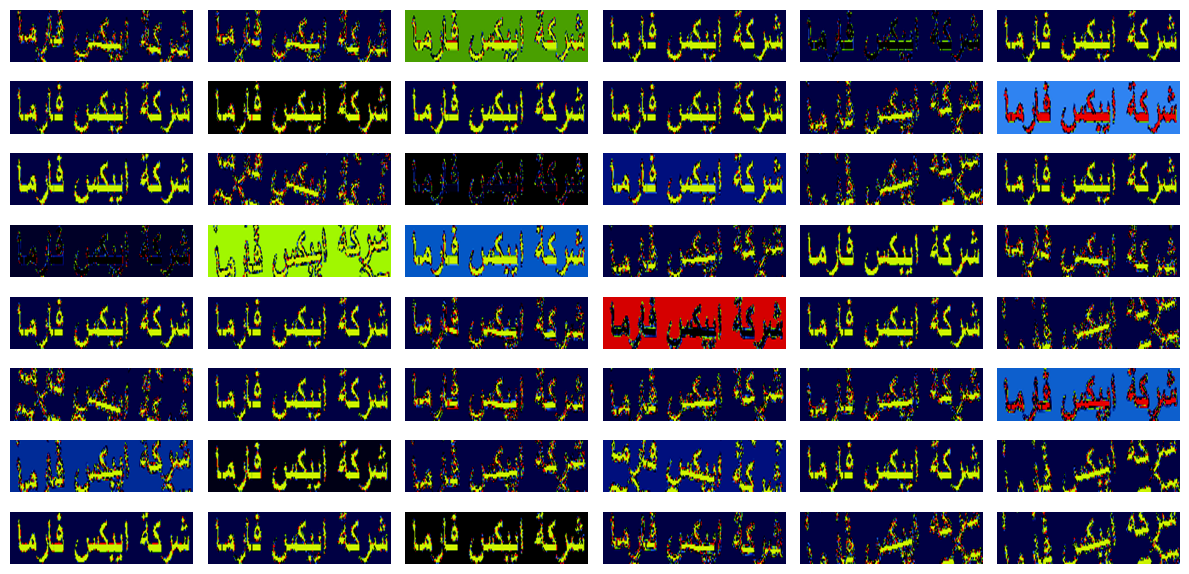

In [32]:
import copy
import matplotlib.pyplot as plt
import torch

def visualize_augmentations(dataset, idx=0, samples=48, cols=6):
    dataset = copy.deepcopy(dataset)
    # dataset.augmentation = None  # Disable augmentation for visualization
    figure, ax = plt.subplots(nrows=samples // cols, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        item = dataset[idx]
        image = item["pixel_values"]  # Access the image tensor
        ax.ravel()[i].imshow(image.permute(1, 2, 0).numpy())  # Convert and display the image
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

# Example usage
visualize_augmentations(train_df_,idx=6)

### Monkey-patch for SuryaADETRDecoderSdpaCrossAttention class

In [34]:
# Monkey-patch the SuryaADETRDecoderSdpaCrossAttention class
def patch_cross_attention(cls):
    # Add key_states and value_states attributes
    cls.key_states = None
    cls.value_states = None

    # Save the original forward method
    # original_forward = cls.forward
    
    def patched_forward(self, hidden_states, encoder_hidden_states, attention_mask=None, encoder_attention_mask=None, use_cache=False):
        def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
            batch, num_key_value_heads, slen, head_dim = hidden_states.shape
            if n_rep == 1:
                return hidden_states
            hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
            return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)
        
        # Get the shape information
        bsz, q_len, _ = hidden_states.size()
        _, v_len, _ = encoder_hidden_states.size()
        
        # Ensure encoder_hidden_states has correct shape
        # print('before: the encoder hidden state shape',encoder_hidden_states.shape)
        if encoder_hidden_states.shape[-1] != self.k_proj.in_features:
            projection_layer = nn.Linear(encoder_hidden_states.shape[-1], self.k_proj.in_features).to(encoder_hidden_states.device)
            encoder_hidden_states = projection_layer(encoder_hidden_states)
        # print('after: the encoder hidden state shape',encoder_hidden_states.shape)
        
        # Create query states
        query_states = self.q_proj(hidden_states)
        query_states = query_states.view(bsz, q_len, self.num_attention_heads, self.head_dim).transpose(1, 2)
        
        # Check if we need to recalculate key/value states
        if not hasattr(self, 'cached_key_states') or self.cached_key_states is None or not use_cache:
            needs_recalculation = True
        else:
            # If batch size changes, we need to recalculate
            needs_recalculation = self.cached_key_states.size(0) != bsz
            
        if needs_recalculation:
            # Calculate new key and value states
            key_states = self.k_proj(encoder_hidden_states)
            value_states = self.v_proj(encoder_hidden_states)
            
            key_states = key_states.view(bsz, v_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)
            value_states = value_states.view(bsz, v_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)
            
            if use_cache:
                # Update cache for future use
                self.cached_key_states = key_states
                self.cached_value_states = value_states
        else:
            # Use cached states
            key_states = self.cached_key_states
            value_states = self.cached_value_states
        
        # Repeat the key and value states if needed
        if hasattr(self, 'num_key_value_groups') and self.num_key_value_groups > 1:
            key_states = repeat_kv(key_states, self.num_key_value_groups)
            value_states = repeat_kv(value_states, self.num_key_value_groups)
        
        # Perform attention
        attn_output = torch.nn.functional.scaled_dot_product_attention(
            query_states,
            key_states,
            value_states,
            attn_mask=None,
            dropout_p=self.attention_dropout if self.training else 0.0,
            scale=self.head_dim**-0.5,
        )
        
        # Reshape output
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.view(bsz, q_len, self.hidden_size)
        attn_output = self.o_proj(attn_output)
        
        return attn_output
    
    # Replace the forward method with the patched version
    cls.forward = patched_forward

# Apply the patch
from surya.model.common.adetr.decoder import SuryaADETRDecoderSdpaCrossAttention
patch_cross_attention(SuryaADETRDecoderSdpaCrossAttention)

## Train

### training with trying the autoregressive

In [35]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
from torch.amp import autocast
import numpy as np

def compute_metrics(logits, labels, processor, ignore_index_=processor.tokenizer.pad_token_id, verbose=False):
    
    preds = torch.argmax(logits, dim=-1)
    mask = labels != ignore_index_
    correct = (preds[mask] == labels[mask]).sum().item()
    total_tokens = mask.sum().item()
    accuracy = correct / total_tokens if total_tokens > 0 else 0.0
    
    pred_texts = processor.tokenizer.batch_decode(preds, skip_special_tokens=True)
    
    # Create a copy of labels to avoid in-place modification
    labels_copy = labels.clone()
    # labels_copy[labels_copy == ignore_index_] = processor.tokenizer.pad_token_id
    true_texts = processor.tokenizer.batch_decode(labels_copy, skip_special_tokens=True)
    
    pred_texts = [fix_math(text) if contains_math(text) else text for text in pred_texts]
    true_texts = [fix_math(text) if contains_math(text) else text for text in true_texts]
    
    cer_scores = []
    wer_scores = []
    for pred, true in zip(pred_texts, true_texts):
        if true.strip() == "":
            if pred.strip() == true.strip():
                cer_scores.append(0.0)
                wer_scores.append(0.0)
            else:
                cer_scores.append(1.0)
                wer_scores.append(1.0)
        else:
            cer_scores.append(cer(true, pred))
            wer_scores.append(wer(true, pred))

    avg_cer = sum(cer_scores) / len(cer_scores)
    avg_wer = sum(wer_scores) / len(wer_scores)

    if verbose:
        print("\nModel Predictions vs Ground Truth:")
        print("Predicted:", pred_texts)
        print("Ground Truth:", true_texts)
        print("-" * 80)

    return accuracy, avg_cer, avg_wer

def pad_to_batch_size(tensor, batch_size):
    current_batch_size = tensor.shape[0]
    if current_batch_size >= batch_size:
        return tensor

    pad_size = batch_size - current_batch_size
    padding = (0, 0) * (tensor.dim() - 1) + (0, pad_size)
    return F.pad(tensor, padding, mode='constant', value=0)

def evaluate(model, processor, val_dataloader, device, criterion, batch_size=TrainingConfig.BATCH_SIZE/8, verbose=True):
    model.to(device)
    model.eval()

    epoch_val_loss, epoch_val_accuracy, epoch_val_cer, epoch_val_wer = 0, 0, 0, 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(val_dataloader, desc="Evaluating")):
          
            # Clear any cached states from previous batches
            for module in model.modules():
                if hasattr(module, 'cached_key_states'):
                    module.cached_key_states = None
                if hasattr(module, 'cached_value_states'):
                    module.cached_value_states = None
            
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            batch_size_actual = pixel_values.shape[0]
            # labels[labels == 0] = processor.tokenizer.pad_token_id
            
            with autocast("cuda"):
                # print('pixel values before pad function',pixel_values.shape)
                batch_pixel_values = pad_to_batch_size(pixel_values, batch_size)
                # print('pixel values after pad function',batch_pixel_values.shape)
                encoder_outputs = model.encoder(pixel_values=batch_pixel_values)
                
                text_encoder_input_ids = torch.arange(
                    model.text_encoder.config.query_token_count,
                    device=device,
                    dtype=torch.long
                ).unsqueeze(0).expand(encoder_outputs.last_hidden_state.size(0), -1)

                encoder_text_hidden_states = model.text_encoder(
                    input_ids=text_encoder_input_ids,
                    cache_position=None,
                    attention_mask=None,
                    encoder_hidden_states=encoder_outputs.last_hidden_state,
                    encoder_attention_mask=None,
                    use_cache=False
                ).hidden_states
                
                batch_decoder_input = torch.full((batch_size_actual, 1), model.config.decoder_start_token_id, device=device)
                # Before your generation loop, initialize all_logits with the first token
                vocab_size = model.decoder.config.vocab_size  # Get vocabulary size from model config
                
                # Create logits for the first token (which should be 1 in your case)
                first_token_logits = torch.zeros((batch_size_actual, vocab_size), device=device, dtype=torch.float)
                first_token_logits[:, 1] = 10.0  # Set high probability for token ID 1
                
                # Initialize all_logits with this first token
                all_logits = [first_token_logits]

                max_length = labels.size(1)
                encoder_attention_mask = (pixel_values.sum(dim=(1, 2)) != 0).float()
                encoder_attention_mask = encoder_attention_mask.unsqueeze(1)
                num_heads = getattr(model.decoder.config, 'num_attention_heads', 8)
                encoder_attention_mask = encoder_attention_mask.expand(-1, num_heads, -1)
                # print('the label max lengh for this batch is',max_length)
                # print('\nthe encoder attention mask is',encoder_attention_mask)

                # Initialize decoder_position_ids
                decoder_position_ids = torch.arange(batch_decoder_input.shape[1], device=model.device)  # ✅ Fix

                for _ in range(max_length - 1): # Generate one fewer token
                    # print('\nthe input to the decoder:',batch_decoder_input)
                    # print('\nthe decoder_position_ids is ',decoder_position_ids)
                    outputs = model.decoder(
                        input_ids=batch_decoder_input,
                        encoder_hidden_states=encoder_text_hidden_states[:batch_size_actual],
                        encoder_attention_mask=encoder_attention_mask,
                        cache_position=decoder_position_ids,
                        use_cache=True
                    )
                    logits = outputs.logits
                    
                    next_token = torch.argmax(logits[:, -1, :], dim=-1).unsqueeze(-1)
                    
                    batch_decoder_input = torch.cat([batch_decoder_input, next_token], dim=-1)
                    all_logits.append(logits[:, -1, :])
                    
                    # Decode and print the current prediction step
                    current_preds = torch.argmax(logits, dim=-1)
                    current_texts = processor.tokenizer.batch_decode(current_preds, skip_special_tokens=True)
                    if verbose:
                        print(f"Step {_ + 1}:")
                        for text in current_texts:
                            print(text)
                        print("-" * 50)

                    # Update decoder_position_ids
                    decoder_position_ids = torch.arange(batch_decoder_input.shape[1], device=model.device)  # ✅ Fix
                
                logits = torch.stack(all_logits, dim=1)
                logits = logits[:batch_size_actual]

            if logits.size(1) > labels.size(1):
                print('the logits size is larger than the label')
                logits = logits[:, :labels.size(1), :]
            elif logits.size(1) < labels.size(1):
                print('the logits size is smaller than the label')
                padding = torch.zeros((batch_size_actual, labels.size(1) - logits.size(1), logits.size(2)), device=device)
                logits = torch.cat([logits, padding], dim=1)

            # loss, accuracy, batch_cer, batch_wer = compute_metrics(
            #     logits, labels, processor, criterion, verbose=verbose
            # )
            loss = criterion(logits.reshape(-1, logits.size(-1)), labels.reshape(-1))
            
            accuracy, batch_cer, batch_wer = compute_metrics(
                logits, labels, processor, verbose=verbose
            )

            epoch_val_loss += loss.item()
            epoch_val_accuracy += accuracy
            epoch_val_cer += batch_cer
            epoch_val_wer += batch_wer

            del pixel_values, labels, attention_mask, encoder_outputs, logits, decoder_position_ids, batch_decoder_input
            torch.cuda.empty_cache()

    avg_val_loss = epoch_val_loss / len(val_dataloader)
    avg_val_accuracy = epoch_val_accuracy / len(val_dataloader)
    avg_val_cer = epoch_val_cer / len(val_dataloader)
    avg_val_wer = epoch_val_wer / len(val_dataloader)
    return avg_val_loss,avg_val_accuracy,avg_val_cer,avg_val_wer

In [38]:
def fine_tune_surya_ocr(
    model,
    processor,
    train_dataloader,
    val_dataloader,
    epochs=3,
    learning_rate=5e-5,
    batch_size=8,
    checkpoint_dir="checkpoints",
    use_mixed_precision=True,  # Enable mixed precision training
    max_grad_norm=1.0,  # Gradient clipping
    patience=3,  # Early stopping patience
    num_checkpoints=3,  # Save model 3 times during training
    accumulation_steps=4,  # Number of steps to accumulate gradients
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    # Freeze image encoder and text encoder
    total_encoder_layers = len(model.encoder.encoder.layers)
    for i in range(total_encoder_layers - 2):
        for param in model.encoder.encoder.layers[i].parameters():
            param.requires_grad = False
    # for param in model.encoder.parameters():
    #     param.requires_grad = False
    
    for param in model.text_encoder.parameters():
        param.requires_grad = False

    # Freeze decoder layers except the last 10
    total_decoder_layers = len(model.decoder.model.layers)
    for i in range(total_decoder_layers):
        for param in model.decoder.model.layers[i].parameters():
            param.requires_grad = False

    # Initialize optimizer, scheduler, and loss function
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)  # Learning rate scheduler
    criterion = torch.nn.CrossEntropyLoss(ignore_index=-100)  # Ignore padding tokens processor.tokenizer.pad_token_id

    # TensorBoard logging
    writer = SummaryWriter(log_dir=os.path.join(checkpoint_dir, "logs"))

    # Early stopping
    best_val_loss = float("inf")
    early_stop_counter = 0

    # Mixed precision training
    scaler = torch.cuda.amp.GradScaler(enabled=use_mixed_precision and device.type == "cuda")

    # Training arguments (for saving)
    training_args = {
        "epochs": epochs,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "use_mixed_precision": use_mixed_precision,
        "max_grad_norm": max_grad_norm,
        "patience": patience,
        "accumulation_steps": accumulation_steps,  # Add accumulation steps to training args
    }

    # Calculate total steps and checkpoint intervals
    total_steps = epochs * len(train_dataloader) // accumulation_steps  # Adjust for accumulated steps
    checkpoint_steps = [total_steps // num_checkpoints * (i + 1) for i in range(num_checkpoints)]

    # Initialize step counter
    global_step = 0
    accumulated_batch = 0  # Counter for accumulation

    for epoch in range(epochs):
        epoch_train_loss = 0
        epoch_train_accuracy = 0
        epoch_train_cer = 0
        epoch_train_wer = 0
        model.train()  # Set the model to training mode

        # Training loop
        for batch_idx, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs} (Training)")):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # Only zero gradients at the beginning of accumulation cycle
            if accumulated_batch % accumulation_steps == 0:
                optimizer.zero_grad()

            # Mixed precision forward pass
            with torch.cuda.amp.autocast(enabled=use_mixed_precision and device.type == "cuda"):
                # Pass pixel values through the image encoder
                encoder_outputs = model.encoder(pixel_values=pixel_values)

                # Prepare input for the text encoder
                text_encoder_input_ids = torch.arange(
                    model.text_encoder.config.query_token_count,
                    device=device,
                    dtype=torch.long
                ).unsqueeze(0).expand(encoder_outputs.last_hidden_state.size(0), -1)

                # Pass encoder hidden states through the text encoder
                encoder_text_hidden_states = model.text_encoder(
                    input_ids=text_encoder_input_ids,
                    cache_position=None,
                    attention_mask=None,
                    encoder_hidden_states=encoder_outputs.last_hidden_state,
                    encoder_attention_mask=None,
                    use_cache=False
                ).hidden_states

                # Pass the text encoder hidden states to the decoder
                outputs = model.decoder(
                    input_ids=labels[:, :-1],  # Shift labels for teacher forcing
                    encoder_hidden_states=encoder_text_hidden_states,
                    attention_mask=attention_mask[:, :-1],
                    use_cache=False  # Disable caching during training
                )
                logits = outputs.logits

                loss = criterion(logits.reshape(-1, logits.size(-1)), labels[:,1:].reshape(-1))
                
                # Scale the loss by accumulation steps for proper gradients
                loss = loss / accumulation_steps

                # Compute metrics (loss, accuracy, CER)
                accuracy, batch_cer, batch_wer = compute_metrics(
                    logits, labels[:,1:], processor, verbose=False
                )

            # Mixed precision backward pass
            scaler.scale(loss).backward()

            # Accumulate metrics for the epoch (using the unscaled loss)
            epoch_train_loss += loss.item() * accumulation_steps  # Undo the scaling for metrics
            epoch_train_accuracy += accuracy
            epoch_train_cer += batch_cer
            epoch_train_wer += batch_wer
            
            accumulated_batch += 1
            
            # Only update weights after accumulation steps
            if accumulated_batch % accumulation_steps == 0 or batch_idx == len(train_dataloader) - 1:
                # Gradient clipping
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)

                # Update weights
                scaler.step(optimizer)
                scaler.update()
                
                # Increment global step after a complete accumulation cycle
                global_step += 1

            # Free up memory
            del pixel_values, labels, attention_mask, encoder_outputs, encoder_text_hidden_states, logits
            torch.cuda.empty_cache()

        # Update learning rate at the end of epoch
        scheduler.step()

        # Compute average training metrics for the epoch
        avg_train_loss = epoch_train_loss / len(train_dataloader)
        avg_train_accuracy = epoch_train_accuracy / len(train_dataloader)
        avg_train_cer = epoch_train_cer / len(train_dataloader)
        avg_train_wer = epoch_train_wer / len(train_dataloader)

        # Log training metrics to TensorBoard
        writer.add_scalar("Loss/Train", avg_train_loss, global_step)
        writer.add_scalar("Accuracy/Train", avg_train_accuracy, global_step)
        writer.add_scalar("CER/Train", avg_train_cer, global_step)
        writer.add_scalar("WER/Train", avg_train_wer, global_step)

        # Validation loop using the autoregressive evaluation method
        avg_val_loss, avg_val_accuracy, avg_val_cer, avg_val_wer = evaluate(
            model, processor, val_dataloader, device, criterion, batch_size=batch_size, verbose=False
        )

        # Log validation metrics to TensorBoard
        writer.add_scalar("Loss/Validation", avg_val_loss, global_step)
        writer.add_scalar("Accuracy/Validation", avg_val_accuracy, global_step)
        writer.add_scalar("CER/Validation", avg_val_cer, global_step)
        writer.add_scalar("WER/Validation", avg_val_wer, global_step)

        # Print metrics
        print(f"Epoch {epoch + 1}/{epochs}, Step {global_step}")
        print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy * 100:.2f}%")
        print(f"Training CER: {avg_train_cer * 100:.2f}%", f"Training WER: {avg_train_wer * 100:.2f}%")
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy * 100:.2f}%")
        print(f"Validation CER: {avg_val_cer * 100:.2f}%, Validation WER: {avg_val_wer * 100:.2f}%")
        print("-" * 50)

        # Save the best model checkpoint
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
            
        else:
            early_stop_counter += 1

        # Early stopping
        # if early_stop_counter >= patience:
        #     print(f"Early stopping at epoch {epoch + 1}!")
        #     break

    # Close TensorBoard writer
    writer.close()

In [39]:
import gc
gc.collect();
torch.cuda.empty_cache()

In [ ]:
fine_tune_surya_ocr(
    model,
    processor,
    train_dataloader,
    val_dataloader,
    epochs=TrainingConfig.EPOCHS,
    learning_rate=TrainingConfig.LEARNING_RATE,
    batch_size=TrainingConfig.BATCH_SIZE,
    accumulation_steps=TrainingConfig.ACCUMULATION_STEPS,  
    checkpoint_dir="checkpoints",
    use_mixed_precision=True,  # Enable mixed precision training
    max_grad_norm=1.0,  # Gradient clipping
    patience=3,  # Early stopping patience
)

<ipython-input-38-85c93ec00dd0>:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_mixed_precision and device.type == "cuda")
Epoch 1/40 (Training):   0%|          | 0/602 [00:00<?, ?it/s]<ipython-input-38-85c93ec00dd0>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_mixed_precision and device.type == "cuda"):
Evaluating:  64%|██████▎   | 82/129 [01:08<00:38,  1.22it/s]

## Save the model

In [ ]:
import os
import json
import torch
from transformers import AutoTokenizer, AutoProcessor  # If you have a tokenizer or processor

def save_model_huggingface_format(model, save_directory, processor=None):
    # Create the save directory if it doesn't exist
    os.makedirs(save_directory, exist_ok=True)

    # Step 1: Save the model's state dictionary
    model_path = os.path.join(save_directory, "pytorch_model.bin")
    torch.save(model.state_dict(), model_path)

    # Step 2: Save the model's configuration
    config = model.config
    config_path = os.path.join(save_directory, "config.json")
    with open(config_path, "w", encoding="utf-8") as f:
        json.dump(config.to_dict(), f, indent=2)

    # Step 3: Save the tokenizer (if applicable)
    if hasattr(model, "tokenizer"):
        tokenizer = model.tokenizer
        tokenizer.save_pretrained(save_directory)

    # Step 4: Save the processor (if applicable)
    if processor is not None:
        processor.save_pretrained(save_directory)

    # Step 5: Save generation config (if applicable)
    if hasattr(model, "generation_config"):
        generation_config = model.generation_config
        generation_config_path = os.path.join(save_directory, "generation_config.json")
        with open(generation_config_path, "w", encoding="utf-8") as f:
            json.dump(generation_config.to_dict(), f, indent=2)

    # Step 6: Save preprocessor config (if applicable)
    if hasattr(model, "preprocessor_config"):
        preprocessor_config = model.preprocessor_config
        preprocessor_config_path = os.path.join(save_directory, "preprocessor_config.json")
        with open(preprocessor_config_path, "w", encoding="utf-8") as f:
            json.dump(preprocessor_config, f, indent=2)

    print(f"Model and processor saved to {save_directory}")

# Example usage
save_model_huggingface_format(model, "fine_tuned_surya_ocr_v3", processor=processor)

## Evaluation

In [ ]:
# import torch
# from tqdm import tqdm
# import torch.nn.functional as F
# from torch.amp import autocast
# import numpy as np

# def compute_metrics(logits, labels, processor, criterion, ignore_index=0, verbose=False):
#     shifted_labels = labels[:,1:]
#     # Add a padding token at the end to maintain length
#     pad_column = torch.full((labels.shape[0], 1), ignore_index, device=labels.device)
#     shifted_labels = torch.cat([shifted_labels, pad_column], dim=1)
    
#     loss = criterion(logits.reshape(-1, logits.size(-1)), shifted_labels.reshape(-1))
#     preds = torch.argmax(logits, dim=-1)
#     # print('the prediction is ',preds)
#     # print('\ntha labels is ',shifted_labels)
#     mask = shifted_labels != ignore_index
#     # print('\nthe label without the ignored index is ',mask)
#     correct = (preds[mask] == shifted_labels[mask]).sum().item()
#     total_tokens = mask.sum().item()
#     accuracy = correct / total_tokens if total_tokens > 0 else 0.0

#     # For decoding, you might need to prepend the first token to predictions
#     # for a fair comparison with original labels
#     first_token = torch.full((preds.size(0), 1), 1, device=preds.device)
#     display_preds = torch.cat([first_token, preds], dim=1)
#     display_preds = display_preds[:, :labels.size(1)]  # Trim to match labels length
    
#     pred_texts = processor.tokenizer.batch_decode(display_preds, skip_special_tokens=True)
#     labels[labels == 0] = processor.tokenizer.pad_token_id
#     true_texts = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)
    
#     pred_texts = [fix_math(text) if contains_math(text) else text for text in pred_texts]
#     true_texts = [fix_math(text) if contains_math(text) else text for text in true_texts]
    
#     cer_scores = []
#     wer_scores = []
#     for pred, true in zip(pred_texts, true_texts):
#         if true.strip() == "":
#             if pred.strip() == true.strip():
#                 cer_scores.append(0.0)
#                 wer_scores.append(0.0)
#             else:
#                 cer_scores.append(1.0)
#                 wer_scores.append(1.0)
#         else:
#             cer_scores.append(cer(true, pred))
#             wer_scores.append(wer(true, pred))

#     avg_cer = sum(cer_scores) / len(cer_scores)
#     avg_wer = sum(wer_scores) / len(wer_scores)

#     if verbose:
#         print("\nModel Predictions vs Ground Truth:")
#         print("Predicted:", pred_texts)
#         print("Ground Truth:", true_texts)
#         print("-" * 80)

#     return loss, accuracy, avg_cer, avg_wer

# def pad_to_batch_size(tensor, batch_size):
#     current_batch_size = tensor.shape[0]
#     if current_batch_size >= batch_size:
#         return tensor

#     pad_size = batch_size - current_batch_size
#     padding = (0, 0) * (tensor.dim() - 1) + (0, pad_size)
#     return F.pad(tensor, padding, mode='constant', value=0)

# def evaluate(model, processor, val_dataloader, device, criterion, batch_size=TrainingConfig.BATCH_SIZE, verbose=False):
#     model.to(device)
#     model.eval()

#     epoch_val_loss, epoch_val_accuracy, epoch_val_cer, epoch_val_wer = 0, 0, 0, 0

#     with torch.no_grad():
#         for batch_idx, batch in enumerate(tqdm(val_dataloader, desc="Evaluating")):
          
#             # Clear any cached states from previous batches
#             for module in model.modules():
#                 if hasattr(module, 'cached_key_states'):
#                     module.cached_key_states = None
#                 if hasattr(module, 'cached_value_states'):
#                     module.cached_value_states = None
            
#             pixel_values = batch["pixel_values"].to(device)
#             labels = batch["labels"].to(device)
#             attention_mask = batch["attention_mask"].to(device)
            
#             batch_size_actual = pixel_values.shape[0]
#             labels[labels == 0] = processor.tokenizer.pad_token_id
            
#             with autocast("cuda"):
#                 batch_pixel_values = pad_to_batch_size(pixel_values, batch_size)
#                 encoder_outputs = model.encoder(pixel_values=batch_pixel_values)
                
#                 text_encoder_input_ids = torch.arange(
#                     model.text_encoder.config.query_token_count,
#                     device=device,
#                     dtype=torch.long
#                 ).unsqueeze(0).expand(encoder_outputs.last_hidden_state.size(0), -1)

#                 encoder_text_hidden_states = model.text_encoder(
#                     input_ids=text_encoder_input_ids,
#                     cache_position=None,
#                     attention_mask=None,
#                     encoder_hidden_states=encoder_outputs.last_hidden_state,
#                     encoder_attention_mask=None,
#                     use_cache=False
#                 ).hidden_states
                
#                 batch_decoder_input = torch.full((batch_size_actual, 1), model.config.decoder_start_token_id, device=device)
#                 # Initialize decoder_position_ids
#                 decoder_position_ids = torch.arange(batch_decoder_input.shape[1], device=model.device)  # ✅ Fix
#                 # Create a tensor of ones with shape [4, 1, 65792]
#                 ones_tensor = torch.ones((4, 65792), device='cuda:0', dtype=torch.float16)
#                 all_logits = []
#                 max_length = labels.size(1)
#                 encoder_attention_mask = (pixel_values.sum(dim=(1, 2)) != 0).float()
#                 encoder_attention_mask = encoder_attention_mask.unsqueeze(1)
#                 num_heads = getattr(model.decoder.config, 'num_attention_heads', 8)
#                 encoder_attention_mask = encoder_attention_mask.expand(-1, num_heads, -1)
#                 # print('the label max lengh for this batch is',max_length)
#                 # print('\nthe encoder attention mask is',encoder_attention_mask)
                
#                 for _ in range(max_length):
#                     # print('\, the input to the decoder:',batch_decoder_input, 'and its shape is', batch_decoder_input.shape)                    
#                     outputs = model.decoder(
#                         input_ids=batch_decoder_input,
#                         encoder_hidden_states=encoder_text_hidden_states[:batch_size_actual],
#                         encoder_attention_mask=encoder_attention_mask,
#                         cache_position=decoder_position_ids,
#                         use_cache=True
#                     )
#                     logits = outputs.logits
#                     # print('logits shape in the output',logits.shape)
#                     all_logits.append(logits[:, -1, :])
#                     # print('all logits shape',all_logits)
                    
#                     next_token = torch.argmax(logits[:, -1, :], dim=-1).unsqueeze(-1)
                    
#                     batch_decoder_input = torch.cat([batch_decoder_input, next_token], dim=-1)
                    
                    
#                     # Decode and print the current prediction step
#                     current_preds = torch.argmax(logits, dim=-1)
#                     current_texts = processor.tokenizer.batch_decode(current_preds, skip_special_tokens=True)
#                     if verbose:
#                         print(f"Step {_ + 1}:")
#                         for text in current_texts:
#                             print(text)
#                         print("-" * 50)
                
#                     # Update decoder_position_ids
#                     decoder_position_ids = torch.arange(batch_decoder_input.shape[1], device=model.device)  # ✅ Fix
                    
                   
#                 logits = torch.stack(all_logits, dim=1)


#             if logits.size(1) > labels.size(1):
#                 print('yes the logits is larger than the labels')
#                 logits = logits[:, :labels.size(1), :]
#             elif logits.size(1) < labels.size(1):
#                 print('yes the logits is samller than the labels')
#                 padding = torch.zeros((batch_size_actual, labels.size(1) - logits.size(1), logits.size(2)), device=device)
#                 logits = torch.cat([logits, padding], dim=1)

#             # # Now trim to match labels length if needed
#             # if aligned_logits.size(1) > labels.size(1):
#             #     aligned_logits = aligned_logits[:, :labels.size(1), :]
#             # elif aligned_logits.size(1) < labels.size(1):
#             #     padding = torch.zeros((batch_size_actual, labels.size(1) - aligned_logits.size(1), aligned_logits.size(2)), device=device, dtype=logits.dtype)
#             #     aligned_logits = torch.cat([aligned_logits, padding], dim=1)

#             loss, accuracy, batch_cer, batch_wer = compute_metrics(
#                 logits, labels, processor, criterion, verbose=verbose and batch_idx == 0
#             )
#             epoch_val_loss += loss.item()
#             epoch_val_accuracy += accuracy
#             epoch_val_cer += batch_cer
#             epoch_val_wer += batch_wer

#             del pixel_values, labels, attention_mask, encoder_outputs, logits
#             torch.cuda.empty_cache()

#     avg_val_loss = epoch_val_loss / len(val_dataloader)
#     avg_val_accuracy = epoch_val_accuracy / len(val_dataloader)
#     avg_val_cer = epoch_val_cer / len(val_dataloader)
#     avg_val_wer = epoch_val_wer / len(val_dataloader)

#     print("\nEvaluation Metrics:")
#     print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy * 100:.2f}%")
#     print(f"Validation CER: {avg_val_cer * 100:.2f}%, Validation WER: {avg_val_wer * 100:.2f}%")
#     print("-" * 50)

In [ ]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
from torch.amp import autocast
import numpy as np

def compute_metrics(logits, labels, processor, criterion, ignore_index=0, verbose=False):
    loss = criterion(logits.reshape(-1, logits.size(-1)), labels.reshape(-1))
    preds = torch.argmax(logits, dim=-1)
    # print('the prediction is ',preds)
    # print('\ntha labels is ',labels)
    mask = labels != ignore_index
    correct = (preds[mask] == labels[mask]).sum().item()
    total_tokens = mask.sum().item()
    accuracy = correct / total_tokens if total_tokens > 0 else 0.0
    pred_texts = processor.tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels[labels == 0] = processor.tokenizer.pad_token_id
    true_texts = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    pred_texts = [fix_math(text) if contains_math(text) else text for text in pred_texts]
    true_texts = [fix_math(text) if contains_math(text) else text for text in true_texts]
    
    cer_scores = []
    wer_scores = []
    for pred, true in zip(pred_texts, true_texts):
        if true.strip() == "":
            if pred.strip() == true.strip():
                cer_scores.append(0.0)
                wer_scores.append(0.0)
            else:
                cer_scores.append(1.0)
                wer_scores.append(1.0)
        else:
            cer_scores.append(cer(true, pred))
            wer_scores.append(wer(true, pred))

    avg_cer = sum(cer_scores) / len(cer_scores)
    avg_wer = sum(wer_scores) / len(wer_scores)

    if verbose:
        print("\nModel Predictions vs Ground Truth:")
        print("Predicted:", pred_texts)
        print("Ground Truth:", true_texts)
        print("-" * 80)

    return loss, accuracy, avg_cer, avg_wer

def pad_to_batch_size(tensor, batch_size):
    current_batch_size = tensor.shape[0]
    if current_batch_size >= batch_size:
        return tensor

    pad_size = batch_size - current_batch_size
    padding = (0, 0) * (tensor.dim() - 1) + (0, pad_size)
    return F.pad(tensor, padding, mode='constant', value=0)

def evaluate(model, processor, val_dataloader, device, criterion, batch_size=TrainingConfig.BATCH_SIZE, verbose=False):
    model.to(device)
    model.eval()

    epoch_val_loss, epoch_val_accuracy, epoch_val_cer, epoch_val_wer = 0, 0, 0, 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(val_dataloader, desc="Evaluating")):
          
            # Clear any cached states from previous batches
            for module in model.modules():
                if hasattr(module, 'cached_key_states'):
                    module.cached_key_states = None
                if hasattr(module, 'cached_value_states'):
                    module.cached_value_states = None
            
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            batch_size_actual = pixel_values.shape[0]
            labels[labels == 0] = processor.tokenizer.pad_token_id
            
            with autocast("cuda"):
                batch_pixel_values = pad_to_batch_size(pixel_values, batch_size)
                encoder_outputs = model.encoder(pixel_values=batch_pixel_values)
                
                text_encoder_input_ids = torch.arange(
                    model.text_encoder.config.query_token_count,
                    device=device,
                    dtype=torch.long
                ).unsqueeze(0).expand(encoder_outputs.last_hidden_state.size(0), -1)

                encoder_text_hidden_states = model.text_encoder(
                    input_ids=text_encoder_input_ids,
                    cache_position=None,
                    attention_mask=None,
                    encoder_hidden_states=encoder_outputs.last_hidden_state,
                    encoder_attention_mask=None,
                    use_cache=False
                ).hidden_states
                
                batch_decoder_input = torch.full((batch_size_actual, 1), model.config.decoder_start_token_id, device=device)
                # Initialize decoder_position_ids
                decoder_position_ids = torch.arange(batch_decoder_input.shape[1], device=model.device)  # ✅ Fix
                # Create a tensor of ones with shape [4, 1, 65792]
                ones_tensor = torch.ones((4, 65792), device='cuda:0', dtype=torch.float16)
                # all_logits = []
                max_length = labels.size(1)
                encoder_attention_mask = (pixel_values.sum(dim=(1, 2)) != 0).float()
                encoder_attention_mask = encoder_attention_mask.unsqueeze(1)
                num_heads = getattr(model.decoder.config, 'num_attention_heads', 8)
                encoder_attention_mask = encoder_attention_mask.expand(-1, num_heads, -1)
                # print('the label max lengh for this batch is',max_length)
                # print('\nthe encoder attention mask is',encoder_attention_mask)

                # Before your generation loop, initialize all_logits with the first token
                # Create logits for the first token (which should be 1 in your case)
                vocab_size = model.decoder.config.vocab_size  # Get vocabulary size from model config
                first_token_logits = torch.zeros((batch_size_actual, vocab_size), device=device, dtype=torch.float)
                first_token_logits[:, 1] = 10.0  # Set high probability for token ID 1
                # Initialize all_logits with this first token
                all_logits = [first_token_logits]

                for _ in range(max_length - 1):
                    # print('\, the input to the decoder:',batch_decoder_input, 'and its shape is', batch_decoder_input.shape)                    
                    outputs = model.decoder(
                        input_ids=batch_decoder_input,
                        encoder_hidden_states=encoder_text_hidden_states[:batch_size_actual],
                        encoder_attention_mask=encoder_attention_mask,
                        cache_position=decoder_position_ids,
                        use_cache=True
                    )
                    logits = outputs.logits
                    # print('logits shape in the output',logits.shape)
                    all_logits.append(logits[:, -1, :])
                    # print('all logits shape',all_logits)
                    
                    next_token = torch.argmax(logits[:, -1, :], dim=-1).unsqueeze(-1)
                    
                    batch_decoder_input = torch.cat([batch_decoder_input, next_token], dim=-1)
                    
                    
                    # Decode and print the current prediction step
                    current_preds = torch.argmax(logits, dim=-1)
                    current_texts = processor.tokenizer.batch_decode(current_preds, skip_special_tokens=True)
                    if verbose:
                        print(f"Step {_ + 1}:")
                        for text in current_texts:
                            print(text)
                        print("-" * 50)
                
                    # Update decoder_position_ids
                    decoder_position_ids = torch.arange(batch_decoder_input.shape[1], device=model.device)  # ✅ Fix
                    
                logits = torch.stack(all_logits, dim=1)

            if logits.size(1) > labels.size(1):
                print('yes the logits is larger than the labels')
                logits = logits[:, :labels.size(1), :]
            elif logits.size(1) < labels.size(1):
                print('yes the logits is samller than the labels')
                padding = torch.zeros((batch_size_actual, labels.size(1) - logits.size(1), logits.size(2)), device=device)
                logits = torch.cat([logits, padding], dim=1)


            loss, accuracy, batch_cer, batch_wer = compute_metrics(
                logits, labels, processor, criterion, verbose=verbose and batch_idx == 0
            )
            epoch_val_loss += loss.item()
            epoch_val_accuracy += accuracy
            epoch_val_cer += batch_cer
            epoch_val_wer += batch_wer

            del pixel_values, labels, attention_mask, encoder_outputs, logits
            torch.cuda.empty_cache()

    avg_val_loss = epoch_val_loss / len(val_dataloader)
    avg_val_accuracy = epoch_val_accuracy / len(val_dataloader)
    avg_val_cer = epoch_val_cer / len(val_dataloader)
    avg_val_wer = epoch_val_wer / len(val_dataloader)

    print("\nEvaluation Metrics:")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy * 100:.2f}%")
    print(f"Validation CER: {avg_val_cer * 100:.2f}%, Validation WER: {avg_val_wer * 100:.2f}%")
    print("-" * 50)

In [ ]:
import gc
gc.collect();
torch.cuda.empty_cache()

In [ ]:
# Example Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
evaluate(model=model, processor=processor, val_dataloader=test_dataloader, device=device, criterion=criterion, verbose=False)

In [ ]:
#using the shifted label and pad to solve this issue
# Evaluation Metrics:
# Validation Loss: 1.4995, Validation Accuracy: 89.77%
# Validation CER: 12.52%, Validation WER: 19.39%
# --------------------------------------------------

In [ ]:
# # adding the cashe position, but no great effect
# Evaluating:   1%|          | 1/111 [00:00<01:12,  1.52it/s]

# Model Predictions vs Ground Truth:
# Predicted: ['أتعاب مهنية', '(١,٢٦١,٥٠٧)', '٢٠١٥', '١٩,٦٠٤,٩٧٧']
# Ground Truth: ['أتعاب مهنية', '(١,٢٦١,٥٠٧)', '٢٠١٥', '١٩,٦٠٤,٩٧٧']
# --------------------------------------------------------------------------------
# Evaluating: 100%|██████████| 111/111 [00:42<00:00,  2.58it/s]

# Evaluation Metrics:
# Validation Loss: 19.0086, Validation Accuracy: 3.05%
# Validation CER: 16.84%, Validation WER: 26.88%
# --------------------------------------------------


In [ ]:
# replacing softmax with argmax
# Evaluating:   1%|          | 1/111 [00:00<01:17,  1.43it/s]

# Model Predictions vs Ground Truth:
# Predicted: ['أتعاب مهنية', '(١,٢٦١,٥٠٧)', '٢٠١٥', '١٩,٦٠٤,٩٧٧']
# Ground Truth: ['أتعاب مهنية', '(١,٢٦١,٥٠٧)', '٢٠١٥', '١٩,٦٠٤,٩٧٧']
# --------------------------------------------------------------------------------
# Evaluating: 100%|██████████| 111/111 [00:43<00:00,  2.58it/s]

# Evaluation Metrics:
# Validation Loss: 19.0086, Validation Accuracy: 3.05%
# Validation CER: 16.84%, Validation WER: 26.88%
# --------------------------------------------------
# with softmax
# Evaluating:   1%|          | 1/111 [00:00<01:17,  1.42it/s]

# Model Predictions vs Ground Truth:
# Predicted: ['أتعاب مهنية', '(١,٢٦١,٥٠٧)', '٢٠١٥', '١٩,٦٠٤,٩٧٧']
# Ground Truth: ['أتعاب مهنية', '(١,٢٦١,٥٠٧)', '٢٠١٥', '١٩,٦٠٤,٩٧٧']
# --------------------------------------------------------------------------------
# Evaluating: 100%|██████████| 111/111 [00:43<00:00,  2.55it/s]

# Evaluation Metrics:
# Validation Loss: 19.1013, Validation Accuracy: 2.87%
# Validation CER: 17.23%, Validation WER: 35.00%
# --------------------------------------------------